In [1]:
import warnings
warnings.filterwarnings(action='ignore')
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import HuberRegressor
from sklearn import metrics
from sklearn.preprocessing import StandardScaler # solamente para la comparación da la improtancia entre variables explicativas
from scipy.stats import kurtosis, skew
import matplotlib.pyplot as plt
import seaborn as sns
import os
pd.set_option('display.max_columns', None)
plt.style.use('bmh')

In [2]:
def correlacion(dataframe, grafica=True, matrix=True, tamaño =(6, 4)):
    '''Devuelve la matriz de correlación de un dataframe
    y sí grafica=True, muestra un mapa de calor de la matriz de correlación'''
    corr=dataframe.corr()
    if grafica==True:
      fig = plt.figure(figsize = tamaño)
      ax = sns.heatmap(corr,
                       vmin = -1,
                       vmax = 1,
                       center = 0,
                       cmap = "coolwarm",
                       annot = True,
                       fmt=".2f",
                       square = True)
      ax.set_xticklabels(ax.get_xticklabels(),
                         rotation = 45,
                         horizontalalignment ='right')
    if matrix==True:
      return corr

In [3]:
def describe_datos(df):
  unicos =[]
  for col in df:
    unicos.append(df[col].unique())
  unicos = pd.Series(unicos, index=df.columns)
  descripcion = pd.concat([df.dtypes, df.isna().sum(),df.nunique(),unicos], axis=1)
  descripcion.columns = ['dtypes', 'null','nunique','unique' ]
  return(descripcion)

In [4]:
pathDatos = os.path.join(os.path.pardir,'datos')

In [5]:
# Variables respuesta
Ys = pd.read_csv(os.path.join(pathDatos,'y_train.csv'),index_col=[0], sep=',',)
print(Ys.shape)
Ys.head(2)

(219337, 3)


,delta selection-departure,delta departure-presentation,delta selection-presentation
emergency vehicle selection,,,
5105452,86,324,410
4720915,164,297,461


In [6]:
# Se puede verificar si la última columna es la suma de las otras dos
(Ys.iloc[:,0] + Ys.iloc[:,1] == Ys.iloc[:,2]).sum()==len(Ys)

True

*Nos vamos a concentrar en el tiempo desde la salida del vehículo hasta la presentación en el lugar del siniestro*

In [7]:
y = Ys['delta departure-presentation']

**Cargar características**

In [8]:
X = pd.read_csv(os.path.join(pathDatos,'x_train.csv'),sep=',', index_col=[0], parse_dates=['selection time'] )
print(X.shape)
X.head(2)

(219337, 25)


,intervention,alert reason category,alert reason,intervention on public roads,floor,location of the event,longitude intervention,latitude intervention,emergency vehicle,emergency vehicle type,rescue center,selection time,date key sélection,time key sélection,status preceding selection,delta status preceding selection-selection,departed from its rescue center,longitude before departure,latitude before departure,delta position gps previous departure-departure,GPS tracks departure-presentation,GPS tracks datetime departure-presentation,OSRM response,OSRM estimated distance,OSRM estimated duration
emergency vehicle selection,,,,,,,,,,,,,,,,,,,,,,,,,
5105452,13264186,3,2162,0,0,148.0,2.284796,48.879669,4511,VSAV BSPP,2447,2018-07-08 19:02:43.990,20180708,190243,Rentré,2027,1,2.288053,48.884698,NaN,"2.289000,48.885113;2.288861,48.884998;2.288000...",2018-07-08 19:04:43;2018-07-08 19:05:55;2018-0...,"{""code"":""Ok"",""routes"":[{""geometry"":""}yjiH}x}L_...",952.5,105.8
4720915,12663715,3,2124,0,1,136.0,2.247464,48.818191,4327,PSE,2464,2018-01-04 09:02:59.470,20180104,90259,Rentré,28233,1,2.268519,48.823958,NaN,NaN,NaN,"{""code"":""Ok"",""routes"":[{""geometry"":""u|~hHy`zL_...",2238.5,243.2


In [9]:
X.columns

Index(['intervention', 'alert reason category', 'alert reason',
       'intervention on public roads', 'floor', 'location of the event',
       'longitude intervention', 'latitude intervention', 'emergency vehicle',
       'emergency vehicle type', 'rescue center', 'selection time',
       'date key sélection', 'time key sélection',
       'status preceding selection',
       'delta status preceding selection-selection',
       'departed from its rescue center', 'longitude before departure',
       'latitude before departure',
       'delta position gps previous departure-departure',
       'GPS tracks departure-presentation',
       'GPS tracks datetime departure-presentation', 'OSRM response',
       'OSRM estimated distance', 'OSRM estimated duration'],
      dtype='object')

In [10]:
describe_datos(X)

,dtypes,null,nunique,unique
intervention,int64,0,200894,"[13264186, 12663715, 13675521, 12695745, 13698..."
alert reason category,int64,0,9,"[3, 9, 6, 1, 2, 5, 7, 4, 8]"
alert reason,int64,0,126,"[2162, 2124, 2163, 2112, 2711, 2113, 2135, 212..."
intervention on public roads,int64,0,2,"[0, 1]"
floor,int64,0,45,"[0, 1, 2, 3, 4, 5, -1, 8, 11, 16, 6, 7, 12, -3..."
location of the event,float64,12710,210,"[148.0, 136.0, 139.0, 104.0, 157.0, 199.0, 140..."
longitude intervention,float64,0,83484,"[2.284796, 2.247464, 2.258328, 2.393832, 2.458..."
latitude intervention,float64,0,74503,"[48.879669, 48.818191, 48.836759, 48.776526, 4..."
emergency vehicle,int64,0,749,"[4511, 4327, 4509, 5731, 5623, 4319, 4215, 588..."
emergency vehicle type,object,0,75,"[VSAV BSPP, PSE, VLR BSPP, EPAN, EPA BSPP, FPT..."


La cantidad de intervenciones **intervention** en los datos no es igual a la cantidad de vehículos **emergency vehicle**, De manera que existen intervenciones que son atendidas por más de un vehiculo de emergencia

el análisis lo vamos a hacer por vehículo

**Unir caracteristicas con étiquetas**

In [11]:
df = pd.concat([X,y], axis=1)
print(df.shape)
df.head(2)

(219337, 26)


,intervention,alert reason category,alert reason,intervention on public roads,floor,location of the event,longitude intervention,latitude intervention,emergency vehicle,emergency vehicle type,rescue center,selection time,date key sélection,time key sélection,status preceding selection,delta status preceding selection-selection,departed from its rescue center,longitude before departure,latitude before departure,delta position gps previous departure-departure,GPS tracks departure-presentation,GPS tracks datetime departure-presentation,OSRM response,OSRM estimated distance,OSRM estimated duration,delta departure-presentation
emergency vehicle selection,,,,,,,,,,,,,,,,,,,,,,,,,,
5105452,13264186,3,2162,0,0,148.0,2.284796,48.879669,4511,VSAV BSPP,2447,2018-07-08 19:02:43.990,20180708,190243,Rentré,2027,1,2.288053,48.884698,NaN,"2.289000,48.885113;2.288861,48.884998;2.288000...",2018-07-08 19:04:43;2018-07-08 19:05:55;2018-0...,"{""code"":""Ok"",""routes"":[{""geometry"":""}yjiH}x}L_...",952.5,105.8,324
4720915,12663715,3,2124,0,1,136.0,2.247464,48.818191,4327,PSE,2464,2018-01-04 09:02:59.470,20180104,90259,Rentré,28233,1,2.268519,48.823958,NaN,NaN,NaN,"{""code"":""Ok"",""routes"":[{""geometry"":""u|~hHy`zL_...",2238.5,243.2,297


In [12]:
df.rename(columns={'delta departure-presentation':'y'}, inplace=True)

In [13]:
df.head()

,intervention,alert reason category,alert reason,intervention on public roads,floor,location of the event,longitude intervention,latitude intervention,emergency vehicle,emergency vehicle type,rescue center,selection time,date key sélection,time key sélection,status preceding selection,delta status preceding selection-selection,departed from its rescue center,longitude before departure,latitude before departure,delta position gps previous departure-departure,GPS tracks departure-presentation,GPS tracks datetime departure-presentation,OSRM response,OSRM estimated distance,OSRM estimated duration,y
emergency vehicle selection,,,,,,,,,,,,,,,,,,,,,,,,,,
5105452,13264186,3,2162,0,0,148.0,2.284796,48.879669,4511,VSAV BSPP,2447,2018-07-08 19:02:43.990,20180708,190243,Rentré,2027,1,2.288053,48.884698,NaN,"2.289000,48.885113;2.288861,48.884998;2.288000...",2018-07-08 19:04:43;2018-07-08 19:05:55;2018-0...,"{""code"":""Ok"",""routes"":[{""geometry"":""}yjiH}x}L_...",952.5,105.8,324
4720915,12663715,3,2124,0,1,136.0,2.247464,48.818191,4327,PSE,2464,2018-01-04 09:02:59.470,20180104,90259,Rentré,28233,1,2.268519,48.823958,NaN,NaN,NaN,"{""code"":""Ok"",""routes"":[{""geometry"":""u|~hHy`zL_...",2238.5,243.2,297
5365374,13675521,3,2163,0,2,139.0,2.258328,48.836759,4509,VSAV BSPP,2438,2018-11-16 10:11:47.777,20181116,101147,Disponible,1981,0,2.272944,48.850498,33.0,"2.272972,48.850498;2.269056,48.847443;2.262611...",2018-11-16 10:14:31;2018-11-16 10:15:43;2018-1...,"{""code"":""Ok"",""routes"":[{""geometry"":""_cdiHo}zLm...",3026.4,295.4,365
4741586,12695745,3,2162,0,0,136.0,2.393832,48.776526,5731,VSAV BSPP,2510,2018-01-15 00:38:46.820,20180115,3846,Rentré,1842,1,2.388940,48.787732,NaN,"2.394278,48.782112;2.393639,48.776833",2018-01-15 00:42:46;2018-01-15 00:43:58,"{""code"":""Ok"",""routes"":[{""geometry"":""sywhH_pqMy...",1934.2,166.6,160
5381209,13698743,3,2162,0,3,104.0,2.458610,48.875751,5623,VSAV BSPP,2478,2018-11-24 00:34:26.017,20181124,3426,Rentré,2716,1,2.439331,48.863814,NaN,"2.439472,48.863724;2.439583,48.863777;2.440917...",2018-11-24 00:37:10;2018-11-24 00:38:22;2018-1...,"{""code"":""Ok"",""routes"":[{""geometry"":""wvfiHgn{Mj...",2706.7,262.6,523


<Axes: xlabel='y', ylabel='Count'>

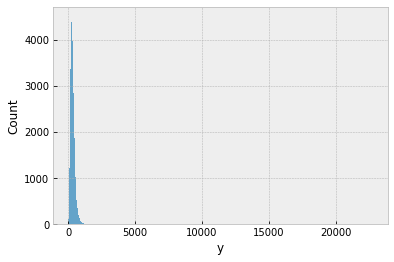

In [14]:
sns.histplot(data=df, x='y')

In [15]:
df.y.describe(percentiles=[.1,.2,.3,.4,.5,.6,.7,.8,.9,.95,.975])

count    219337.000000
mean        356.161026
std         228.381939
min           1.000000
10%         167.000000
20%         212.000000
30%         249.000000
40%         283.000000
50%         319.000000
60%         358.000000
70%         406.000000
80%         468.000000
90%         572.000000
95%         683.200000
97.5%       806.000000
max       22722.000000
Name: y, dtype: float64

In [16]:
df['y'].quantile(.995)

1229.0

In [17]:
df['outlier'] = 0
filtro_out = df['y'] > df['y'].quantile(.995)
df.loc[filtro_out,'outlier'] = 1

In [18]:
df['outlier'].value_counts()

outlier
0    218242
1      1095
Name: count, dtype: int64

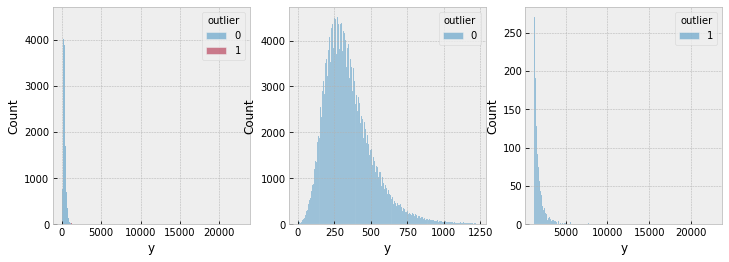

In [19]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
for dat, subplot in zip((df, df[-filtro_out], df[filtro_out]), ax.flatten()):
  sns.histplot(x='y', hue='outlier',
               data=dat, ax=subplot )
plt.show()

In [20]:
pd.pivot_table(
    data = df,
    index='alert reason',
    columns='alert reason category',
    values = 'intervention',
    aggfunc='count',
    fill_value=0
              )

alert reason category,1,2,3,4,5,6,7,8,9
alert reason,,,,,,,,,
1911,119,0,0,0,0,0,0,0,0
1912,792,0,0,0,0,0,0,0,0
1914,1036,0,0,0,0,0,0,0,0
1917,4,0,0,0,0,0,0,0,0
1918,1389,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
7914,0,0,0,0,0,104,0,0,0
10821,0,0,0,0,0,0,0,0,2
10971,0,0,0,0,0,0,0,0,1


In [21]:
#Borrar columnas que no utilizaremos

col_borrar=['intervention',  #identificador de la intervención
            'emergency vehicle',  #id 749 vehículo de emergencia, que están agrupada en 'emergency vehicle type'
            'alert reason', # 126 categorías, que están resumidas en 'alert reason category'

            # Variables geográficas
            'OSRM response', #rutas
            'GPS tracks departure-presentation', #rutas
            'GPS tracks datetime departure-presentation', #rutas
            'longitude intervention', 'latitude intervention', #coordenadas
            'longitude before departure',  #coordenadas
            'latitude before departure',    #coordenadas

            # Redundantes
            'date key sélection', 'time key sélection', # redundantes con 'selection time'

            #variable no relaccionadas con delta departure-presentation
            'status preceding selection',
            'rescue center', # id 94 centros de rescate, estacionamiento de los vehícuos
            'delta status preceding selection-selection',
            'departed from its rescue center',
            'delta position gps previous departure-departure'
            ]
df = df.drop(columns= col_borrar)

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 219337 entries, 5105452 to 4868867
Data columns (total 10 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   alert reason category         219337 non-null  int64         
 1   intervention on public roads  219337 non-null  int64         
 2   floor                         219337 non-null  int64         
 3   location of the event         206627 non-null  float64       
 4   emergency vehicle type        219337 non-null  object        
 5   selection time                219337 non-null  datetime64[ns]
 6   OSRM estimated distance       219337 non-null  float64       
 7   OSRM estimated duration       219337 non-null  float64       
 8   y                             219337 non-null  int64         
 9   outlier                       219337 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(5), object(1)
memory usage: 18.4+ MB


In [22]:
df.dtypes

alert reason category                    int64
intervention on public roads             int64
floor                                    int64
location of the event                  float64
emergency vehicle type                  object
selection time                  datetime64[ns]
OSRM estimated distance                float64
OSRM estimated duration                float64
y                                        int64
outlier                                  int64
dtype: object

In [23]:
# Separamos nuestras variables de acuerdo al tipo de dato proporcionado en la descripción de las variables 
categoricas=['alert reason category','location of the event',
             'emergency vehicle type']
df[categoricas] = df[categoricas].astype('object')

df['intervention on public roads']=df['intervention on public roads'].astype('bool')
describe_datos(df)

,dtypes,null,nunique,unique
alert reason category,object,0,9,"[3, 9, 6, 1, 2, 5, 7, 4, 8]"
intervention on public roads,bool,0,2,"[False, True]"
floor,int64,0,45,"[0, 1, 2, 3, 4, 5, -1, 8, 11, 16, 6, 7, 12, -3..."
location of the event,object,12710,210,"[148.0, 136.0, 139.0, 104.0, 157.0, 199.0, 140..."
emergency vehicle type,object,0,75,"[VSAV BSPP, PSE, VLR BSPP, EPAN, EPA BSPP, FPT..."
selection time,datetime64[ns],0,219285,"[2018-07-08 19:02:43.990000, 2018-01-04 09:02:..."
OSRM estimated distance,float64,0,48461,"[952.5, 2238.5, 3026.4, 1934.2, 2706.7, 1685.8..."
OSRM estimated duration,float64,0,8236,"[105.8, 243.2, 295.4, 166.6, 262.6, 187.7, 301..."
y,int64,0,1909,"[324, 297, 365, 160, 523, 419, 452, 404, 411, ..."
outlier,int64,0,2,"[0, 1]"


**Ingenieria de  variables**

<Axes: xlabel='selection time', ylabel='Count'>

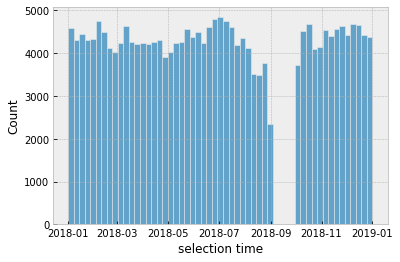

In [24]:
# Obtenemos la hora a partir del campo selection time, tratando de identificar la diferencia en los horarios
sns.histplot(data=df, x='selection time')

In [25]:
df['hora'] = df['selection time'].dt.hour

<Axes: xlabel='hora', ylabel='Count'>

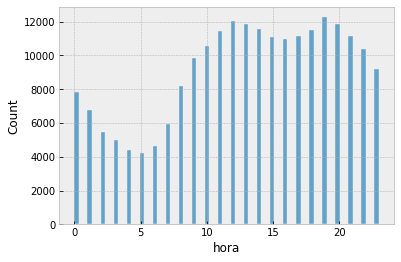

In [26]:
sns.histplot(data=df, x='hora')

<Axes: xlabel='hora', ylabel='y'>

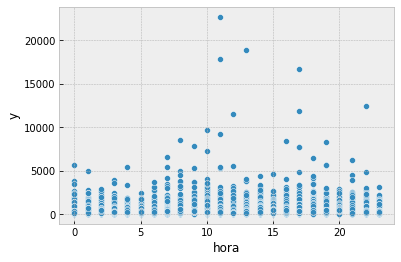

In [27]:
sns.scatterplot(
    data=df,
    x='hora',
    y = 'y'
               )

In [28]:
# Construiremos una variable para identificar si la fecha es fin de semana o hábil
df['fin_semana'] = np.where(df['selection time'].dt.weekday > 4, 1, 0)

<Axes: xlabel='hora', ylabel='y'>

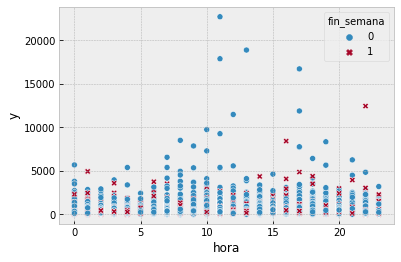

In [29]:
sns.scatterplot(
    data=df,
    x='hora',
    y = 'y',
    hue='fin_semana',
    style='fin_semana'
               )

In [30]:
# Variables con valores Null
df.isnull().sum()

alert reason category               0
intervention on public roads        0
floor                               0
location of the event           12710
emergency vehicle type              0
selection time                      0
OSRM estimated distance             0
OSRM estimated duration             0
y                                   0
outlier                             0
hora                                0
fin_semana                          0
dtype: int64

**Alternativas**

- Borrar esos renglones,
- borrar esa variable,
- imputar valores:
    - ¿remplazar por ceros?
    - ¿reemplazar por una medida de tendencia central?
    - ¿a parir del conocimiento que nos proporcionan las demás variables?
**¿los valores nulos son aleatorios? ¿se observa algún patrón? ¿borrar los renglónes con valores nulos impacta nuestro modelo?**

<Axes: xlabel='nulos', ylabel='y'>

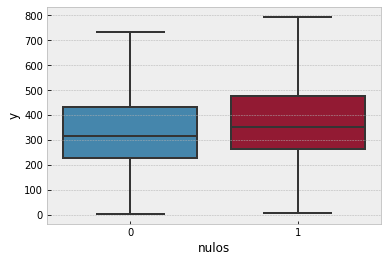

In [31]:
#Distribución de la variable respuesta en registros con y sin valores nulos en "location of the event"
df['nulos'] = np.where(df['location of the event'].isna(),1,0)

sns.boxplot(x = 'nulos' , y = 'y', data = df,showfliers=False)

In [32]:
df.dtypes

alert reason category                   object
intervention on public roads              bool
floor                                    int64
location of the event                   object
emergency vehicle type                  object
selection time                  datetime64[ns]
OSRM estimated distance                float64
OSRM estimated duration                float64
y                                        int64
outlier                                  int64
hora                                     int32
fin_semana                               int32
nulos                                    int32
dtype: object

¿Podemos imputar valores con el conocimiento que tenemos de los demás registros?

,intervention on public roads,floor,OSRM estimated distance,OSRM estimated duration,y,outlier,hora,fin_semana,nulos
intervention on public roads,1.000000,-0.197776,-0.073699,-0.074695,-0.057065,-0.009226,0.004769,0.015281,-0.102594
floor,-0.197776,1.000000,-0.071589,-0.063506,0.002170,-0.006389,-0.017508,0.008261,-0.119134
OSRM estimated distance,-0.073699,-0.071589,1.000000,0.944066,0.449922,0.131621,0.017439,-0.020546,0.308365
OSRM estimated duration,-0.074695,-0.063506,0.944066,1.000000,0.446742,0.117142,0.015603,-0.021052,0.298830
y,-0.057065,0.002170,0.449922,0.446742,1.000000,0.487512,-0.019915,-0.040053,0.067692
outlier,-0.009226,-0.006389,0.131621,0.117142,0.487512,1.000000,-0.000593,-0.007653,0.045558
hora,0.004769,-0.017508,0.017439,0.015603,-0.019915,-0.000593,1.000000,-0.017621,0.010468
fin_semana,0.015281,0.008261,-0.020546,-0.021052,-0.040053,-0.007653,-0.017621,1.000000,-0.007231
nulos,-0.102594,-0.119134,0.308365,0.298830,0.067692,0.045558,0.010468,-0.007231,1.000000


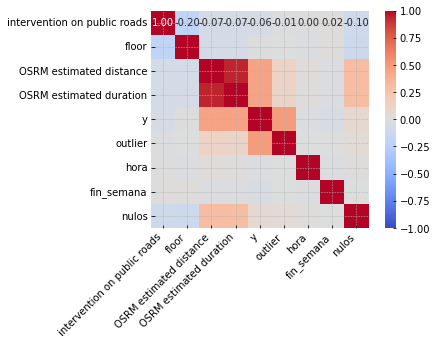

In [33]:
col_numericas = list(df.select_dtypes(include=['int64', 'int32','float64', 'bool']).columns)
correlacion(df[col_numericas])

<Axes: xlabel='nulos', ylabel='alert reason category'>

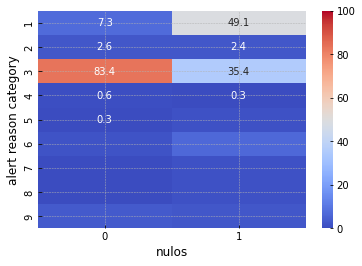

In [34]:
tabla = (pd.crosstab(df['alert reason category'],df['nulos'], normalize = 'columns')*100)

sns.heatmap(tabla,  vmin = 0, vmax = 100, cmap = "coolwarm", annot = True,
            fmt=".1f")

In [35]:
# Para imputar los valores nulos en 'alert reason category', tomamos la moda que le corresponda segun la categoria que tenga en 'location of the event'
dict_alert_location = df.groupby('alert reason category')['location of the event'].agg(pd.Series.mode).to_dict()
dict_alert_location

{1: 131.0,
 2: 149.0,
 3: 139.0,
 4: 139.0,
 5: 148.0,
 6: 148.0,
 7: 148.0,
 8: 131.0,
 9: 139.0}

In [36]:
# remplazamos los valores nulos en 'location of the event' de acuerdo al valor que presenta

df['location of the event'] = df['location of the event'].fillna( df['alert reason category'].map(dict_alert_location))
df['location of the event'].isna().sum()
     

0

In [37]:
df['location of the event'] = df['location of the event'].astype('int').astype('object')

In [38]:
# borrar la columna de nulos
df = df.drop('nulos', axis=1)

# One hot encoding variables categoricas

In [39]:
df[categoricas].nunique()

alert reason category       9
location of the event     210
emergency vehicle type     75
dtype: int64

**¿Vale la pena considerar todas las categorias para el one hot encodig?**

In [40]:
df_column = df['alert reason category']
porcentaje = 99

frecuencia = df_column.value_counts()
sum_acumulada = (df_column.value_counts()/len(df)*100).cumsum().round(2)
pareto_df = pd.DataFrame({'Frecuencia':frecuencia,
                          'Porcentje_acumulado':sum_acumulada,
                          'Limite': porcentaje})
pareto_df

,Frecuencia,Porcentje_acumulado,Limite
alert reason category,,,
3,176787,80.60,99
1,21270,90.30,99
9,7481,93.71,99
2,5705,96.31,99
6,4814,98.50,99
4,1221,99.06,99
7,901,99.47,99
5,781,99.83,99
8,377,100.00,99


In [41]:
pareto_df['Categorías importantes'] = np.where(
    (pareto_df['Limite'] <= pareto_df['Porcentje_acumulado']) &
    (pareto_df['Limite'].shift(1) <= pareto_df['Porcentje_acumulado'].shift(1)),
      0, 100)
pareto_df

,Frecuencia,Porcentje_acumulado,Limite,Categorías importantes
alert reason category,,,,
3,176787,80.60,99,100
1,21270,90.30,99,100
9,7481,93.71,99,100
2,5705,96.31,99,100
6,4814,98.50,99,100
4,1221,99.06,99,100
7,901,99.47,99,0
5,781,99.83,99,0
8,377,100.00,99,0


Categorias: 210
Categorias que hacen el 99%: 96
Categorias importantes = [139, 136, 148, 149, 131, 140, 107, 137, 104, 325, 100, 259, 228, 241, 219, 135, 196, 105, 202, 210, 147, 224, 218, 199, 211, 257, 201, 226, 164, 232, 114, 216, 274, 323, 112, 143, 258, 138, 128, 111, 206, 205, 130, 222, 101, 244, 230, 233, 167, 108, 231, 229, 146, 118, 127, 134, 198, 220, 204, 227, 191, 270, 141, 115, 261, 264, 207, 212, 242, 286, 237, 121, 203, 106, 157, 113, 322, 179, 254, 209, 316, 260, 276, 125, 133, 189, 186, 320, 194, 263, 165, 221, 120, 103, 236, 208]


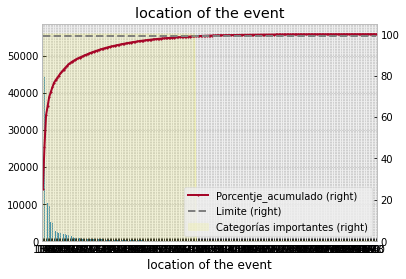

In [42]:
def categorias_utiles_pareto(df_column, porcentaje):
    # Data Frame con datos necesarios.
    frecuencia = df_column.value_counts()
    sum_acumulada = (df_column.value_counts()/len(df)*100).cumsum()
    pareto_df = pd.DataFrame({'Frecuencia':frecuencia,
                              'Porcentje_acumulado':sum_acumulada,
                              'Limite': porcentaje})

    # Obtención de categorías utiles.
    pareto_df['Categorías importantes'] = np.where(
    (pareto_df['Limite'] <= pareto_df['Porcentje_acumulado']) &             \
    (pareto_df['Limite'].shift(1) <= pareto_df['Porcentje_acumulado'].shift(1)),
      0, 100)
    categorias_utiles = pareto_df[pareto_df['Categorías importantes']==100].index.to_list()

   # Imprimir información util.
    print(f'Categorias: {pareto_df.shape[0]}')
    print(f'Categorias que hacen el {porcentaje}%: {len(categorias_utiles)}')
    print(f'Categorias importantes = {categorias_utiles}')


    # Gráfica de Pareto
    fig, axes = plt.subplots()
    ax1 = pareto_df.plot(use_index=True, y='Frecuencia',  kind='bar',
                         ax=axes, legend=False)
    ax2 = pareto_df.plot(use_index=True, y='Porcentje_acumulado', kind='line',
                         marker='D', ms=1, color="C1", ax=axes,
                         secondary_y=True, legend=False).legend(loc='lower right')
    axes.right_ax.set_ylim(0,105)
    ax3 = pareto_df.plot(use_index=True, y='Limite', color="gray", kind='line',
                         linestyle='dashed', ax=axes, secondary_y=True, legend=False).legend(loc='lower right')
    ax4 = pareto_df.plot(use_index=True, y='Categorías importantes',
                         color="yellow", kind='area', ax=axes,
                         secondary_y=True, alpha=0.1, legend=False).legend(loc='lower right')
    plt.title(f'{df_column.name}')

    return categorias_utiles

cat_location = categorias_utiles_pareto(df['location of the event'], 99)

Categorias: 75
Categorias que hacen el 99%: 14
Categorias importantes = ['VSAV BSPP', 'PSE', 'VLR BSPP', 'FPT BSPP', 'AR', 'FA', 'EPA BSPP', 'EPAN', 'CCR BSPP', 'CRF', 'FNPC', 'VID', 'BEAA BSPP', 'EPSA']


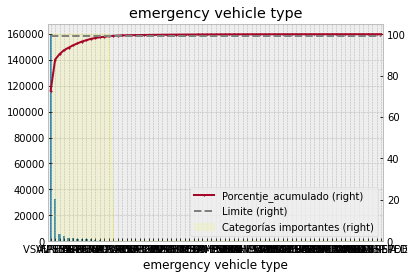

In [43]:
cat_vehicle = categorias_utiles_pareto(df['emergency vehicle type'], 99)

Categorias: 9
Categorias que hacen el 99%: 6
Categorias importantes = [3, 1, 9, 2, 6, 4]


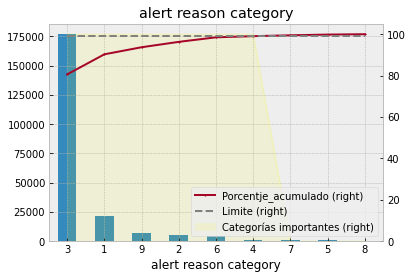

In [44]:
cat_reason = categorias_utiles_pareto(df['alert reason category'], 99)

In [45]:
df['alert reason category'] = np.where(df['alert reason category'].isin(cat_reason),
                                       df['alert reason category'], np.nan)
df['emergency vehicle type'] = np.where(df['emergency vehicle type'].isin(cat_vehicle),
                                       df['emergency vehicle type'], np.nan)
df['location of the event'] = np.where(df['location of the event'].isin(cat_location),
                                       df['location of the event'], np.nan)

# En la transformación previa de las variables categoricas, podríamos cambiar np.nan por 'other',
# pero de esta manera, la categoria a eliminar en get_dummies sería por default sera np.nan

describe_datos(df[categoricas])

,dtypes,null,nunique,unique
alert reason category,object,2059,6,"[3, 9, 6, 1, 2, nan, 4]"
location of the event,object,2189,96,"[148, 136, 139, 104, 157, 199, 140, 107, 325, ..."
emergency vehicle type,object,2166,14,"[VSAV BSPP, PSE, VLR BSPP, EPAN, EPA BSPP, FPT..."


In [46]:
he = pd.get_dummies(df[categoricas])
print(he.shape)
he.head()

(219337, 116)


,alert reason category_1,alert reason category_2,alert reason category_3,alert reason category_4,alert reason category_6,alert reason category_9,location of the event_100,location of the event_101,location of the event_103,location of the event_104,location of the event_105,location of the event_106,location of the event_107,location of the event_108,location of the event_111,location of the event_112,location of the event_113,location of the event_114,location of the event_115,location of the event_118,location of the event_120,location of the event_121,location of the event_125,location of the event_127,location of the event_128,location of the event_130,location of the event_131,location of the event_133,location of the event_134,location of the event_135,location of the event_136,location of the event_137,location of the event_138,location of the event_139,location of the event_140,location of the event_141,location of the event_143,location of the event_146,location of the event_147,location of the event_148,location of the event_149,location of the event_157,location of the event_164,location of the event_165,location of the event_167,location of the event_179,location of the event_186,location of the event_189,location of the event_191,location of the event_194,location of the event_196,location of the event_198,location of the event_199,location of the event_201,location of the event_202,location of the event_203,location of the event_204,location of the event_205,location of the event_206,location of the event_207,location of the event_208,location of the event_209,location of the event_210,location of the event_211,location of the event_212,location of the event_216,location of the event_218,location of the event_219,location of the event_220,location of the event_221,location of the event_222,location of the event_224,location of the event_226,location of the event_227,location of the event_228,location of the event_229,location of the event_230,location of the event_231,location of the event_232,location of the event_233,location of the event_236,location of the event_237,location of the event_241,location of the event_242,location of the event_244,location of the event_254,location of the event_257,location of the event_258,location of the event_259,location of the event_260,location of the event_261,location of the event_263,location of the event_264,location of the event_270,location of the event_274,location of the event_276,location of the event_286,location of the event_316,location of the event_320,location of the event_322,location of the event_323,location of the event_325,emergency vehicle type_AR,emergency vehicle type_BEAA BSPP,emergency vehicle type_CCR BSPP,emergency vehicle type_CRF,emergency vehicle type_EPA BSPP,emergency vehicle type_EPAN,emergency vehicle type_EPSA,emergency vehicle type_FA,emergency vehicle type_FNPC,emergency vehicle type_FPT BSPP,emergency vehicle type_PSE,emergency vehicle type_VID,emergency vehicle type_VLR BSPP,emergency vehicle type_VSAV BSPP
emergency vehicle selection,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5105452,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
4720915,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,

In [47]:
df.columns

Index(['alert reason category', 'intervention on public roads', 'floor',
       'location of the event', 'emergency vehicle type', 'selection time',
       'OSRM estimated distance', 'OSRM estimated duration', 'y', 'outlier',
       'hora', 'fin_semana'],
      dtype='object')

In [48]:
df.shape, he.shape

((219337, 12), (219337, 116))

In [49]:
df = df.drop(columns=categoricas)
df = pd.concat([df, he], axis=1)
df.shape

(219337, 125)

In [50]:
#Llevar la etiqueta hasta la ultima posición

df = df[[c for c in df if c != 'y'] + ['y']]
print(df.shape)
df.info()

(219337, 125)
<class 'pandas.core.frame.DataFrame'>
Index: 219337 entries, 5105452 to 4868867
Columns: 125 entries, intervention on public roads to y
dtypes: bool(117), datetime64[ns](1), float64(2), int32(2), int64(3)
memory usage: 37.9 MB


In [51]:
df.head()

,intervention on public roads,floor,selection time,OSRM estimated distance,OSRM estimated duration,outlier,hora,fin_semana,alert reason category_1,alert reason category_2,alert reason category_3,alert reason category_4,alert reason category_6,alert reason category_9,location of the event_100,location of the event_101,location of the event_103,location of the event_104,location of the event_105,location of the event_106,location of the event_107,location of the event_108,location of the event_111,location of the event_112,location of the event_113,location of the event_114,location of the event_115,location of the event_118,location of the event_120,location of the event_121,location of the event_125,location of the event_127,location of the event_128,location of the event_130,location of the event_131,location of the event_133,location of the event_134,location of the event_135,location of the event_136,location of the event_137,location of the event_138,location of the event_139,location of the event_140,location of the event_141,location of the event_143,location of the event_146,location of the event_147,location of the event_148,location of the event_149,location of the event_157,location of the event_164,location of the event_165,location of the event_167,location of the event_179,location of the event_186,location of the event_189,location of the event_191,location of the event_194,location of the event_196,location of the event_198,location of the event_199,location of the event_201,location of the event_202,location of the event_203,location of the event_204,location of the event_205,location of the event_206,location of the event_207,location of the event_208,location of the event_209,location of the event_210,location of the event_211,location of the event_212,location of the event_216,location of the event_218,location of the event_219,location of the event_220,location of the event_221,location of the event_222,location of the event_224,location of the event_226,location of the event_227,location of the event_228,location of the event_229,location of the event_230,location of the event_231,location of the event_232,location of the event_233,location of the event_236,location of the event_237,location of the event_241,location of the event_242,location of the event_244,location of the event_254,location of the event_257,location of the event_258,location of the event_259,location of the event_260,location of the event_261,location of the event_263,location of the event_264,location of the event_270,location of the event_274,location of the event_276,location of the event_286,location of the event_316,location of the event_320,location of the event_322,location of the event_323,location of the event_325,emergency vehicle type_AR,emergency vehicle type_BEAA BSPP,emergency vehicle type_CCR BSPP,emergency vehicle type_CRF,emergency vehicle type_EPA BSPP,emergency vehicle type_EPAN,emergency vehicle type_EPSA,emergency vehicle type_FA,emergency vehicle type_FNPC,emergency vehicle type_FPT BSPP,emergency vehicle type_PSE,emergency vehicle type_VID,emergency vehicle type_VLR BSPP,emergency vehicle type_VSAV BSPP,y
emergency vehicle selection,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5105452,False,0,2018-07-08 19:02:43.990,952.5,105.8,0,19,1,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,Fa

## ¿Hay variables que no son relevantes para la predicción de la variable respuesta?


In [52]:
numericas = list(df.select_dtypes(include=['int64', 'float64']).columns)
numericas

['floor', 'OSRM estimated distance', 'OSRM estimated duration', 'outlier', 'y']

In [53]:
df[numericas].corr()['y']

floor                      0.002170
OSRM estimated distance    0.449922
OSRM estimated duration    0.446742
outlier                    0.487512
y                          1.000000
Name: y, dtype: float64

## Eliminar variables no relevantes y redundantes
- No relevantes: Análisis de correlación de las explicativas(X) con la etiqueta (y)

- Redundantes: Análisis de correlación entre las variables explicativas (X)

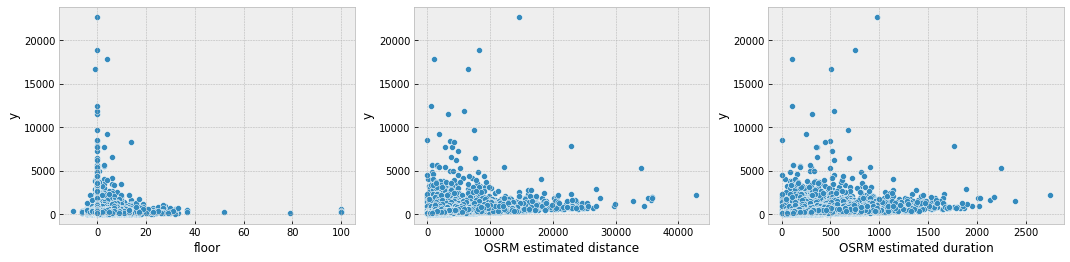

In [55]:
fig, (ax1,ax2, ax3) = plt.subplots(1,3, figsize=(18,4))

sns.scatterplot(x='floor', y='y', data=df, ax=ax1)
sns.scatterplot(x='OSRM estimated distance', y='y',
                data=df, ax=ax2)
sns.scatterplot(x='OSRM estimated duration', y='y',
                data=df, ax=ax3)
plt.show()

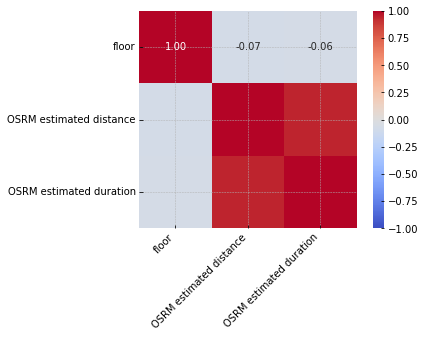

In [56]:
# correlacion de las características numéricas en el conjunto X
corr_matrix = correlacion(df[numericas[:3]])

In [57]:
#Identificar variables redundantes

# Triangulo superior de la matriz de correlación en números absolutos
celda_sobre_diagonal_ppal = np.triu(np.ones_like(corr_matrix), 1).astype(bool)
triangulo_sup = corr_matrix.where(celda_sobre_diagonal_ppal).abs()


# Encontrar las columnas donde la correlación es 1
redundantes = [column for column in triangulo_sup.columns
          if any(triangulo_sup[column] >= .7)]
redundantes
     

['OSRM estimated duration']

In [58]:
df = df.drop(redundantes, axis=1)

In [59]:
y = df['y']
X = df.drop(['selection time', 'y', 'outlier'],
            axis=1)

In [60]:
boleanas = [col for col in X.columns if X[col].nunique() == 2]

In [61]:
X.head()

,intervention on public roads,floor,OSRM estimated distance,hora,fin_semana,alert reason category_1,alert reason category_2,alert reason category_3,alert reason category_4,alert reason category_6,alert reason category_9,location of the event_100,location of the event_101,location of the event_103,location of the event_104,location of the event_105,location of the event_106,location of the event_107,location of the event_108,location of the event_111,location of the event_112,location of the event_113,location of the event_114,location of the event_115,location of the event_118,location of the event_120,location of the event_121,location of the event_125,location of the event_127,location of the event_128,location of the event_130,location of the event_131,location of the event_133,location of the event_134,location of the event_135,location of the event_136,location of the event_137,location of the event_138,location of the event_139,location of the event_140,location of the event_141,location of the event_143,location of the event_146,location of the event_147,location of the event_148,location of the event_149,location of the event_157,location of the event_164,location of the event_165,location of the event_167,location of the event_179,location of the event_186,location of the event_189,location of the event_191,location of the event_194,location of the event_196,location of the event_198,location of the event_199,location of the event_201,location of the event_202,location of the event_203,location of the event_204,location of the event_205,location of the event_206,location of the event_207,location of the event_208,location of the event_209,location of the event_210,location of the event_211,location of the event_212,location of the event_216,location of the event_218,location of the event_219,location of the event_220,location of the event_221,location of the event_222,location of the event_224,location of the event_226,location of the event_227,location of the event_228,location of the event_229,location of the event_230,location of the event_231,location of the event_232,location of the event_233,location of the event_236,location of the event_237,location of the event_241,location of the event_242,location of the event_244,location of the event_254,location of the event_257,location of the event_258,location of the event_259,location of the event_260,location of the event_261,location of the event_263,location of the event_264,location of the event_270,location of the event_274,location of the event_276,location of the event_286,location of the event_316,location of the event_320,location of the event_322,location of the event_323,location of the event_325,emergency vehicle type_AR,emergency vehicle type_BEAA BSPP,emergency vehicle type_CCR BSPP,emergency vehicle type_CRF,emergency vehicle type_EPA BSPP,emergency vehicle type_EPAN,emergency vehicle type_EPSA,emergency vehicle type_FA,emergency vehicle type_FNPC,emergency vehicle type_FPT BSPP,emergency vehicle type_PSE,emergency vehicle type_VID,emergency vehicle type_VLR BSPP,emergency vehicle type_VSAV BSPP
emergency vehicle selection,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5105452,False,0,952.5,19,1,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
4720

In [64]:
X[boleanas] = X[boleanas].apply(lambda row: row.astype(int))

In [65]:
X.head()

,intervention on public roads,floor,OSRM estimated distance,hora,fin_semana,alert reason category_1,alert reason category_2,alert reason category_3,alert reason category_4,alert reason category_6,alert reason category_9,location of the event_100,location of the event_101,location of the event_103,location of the event_104,location of the event_105,location of the event_106,location of the event_107,location of the event_108,location of the event_111,location of the event_112,location of the event_113,location of the event_114,location of the event_115,location of the event_118,location of the event_120,location of the event_121,location of the event_125,location of the event_127,location of the event_128,location of the event_130,location of the event_131,location of the event_133,location of the event_134,location of the event_135,location of the event_136,location of the event_137,location of the event_138,location of the event_139,location of the event_140,location of the event_141,location of the event_143,location of the event_146,location of the event_147,location of the event_148,location of the event_149,location of the event_157,location of the event_164,location of the event_165,location of the event_167,location of the event_179,location of the event_186,location of the event_189,location of the event_191,location of the event_194,location of the event_196,location of the event_198,location of the event_199,location of the event_201,location of the event_202,location of the event_203,location of the event_204,location of the event_205,location of the event_206,location of the event_207,location of the event_208,location of the event_209,location of the event_210,location of the event_211,location of the event_212,location of the event_216,location of the event_218,location of the event_219,location of the event_220,location of the event_221,location of the event_222,location of the event_224,location of the event_226,location of the event_227,location of the event_228,location of the event_229,location of the event_230,location of the event_231,location of the event_232,location of the event_233,location of the event_236,location of the event_237,location of the event_241,location of the event_242,location of the event_244,location of the event_254,location of the event_257,location of the event_258,location of the event_259,location of the event_260,location of the event_261,location of the event_263,location of the event_264,location of the event_270,location of the event_274,location of the event_276,location of the event_286,location of the event_316,location of the event_320,location of the event_322,location of the event_323,location of the event_325,emergency vehicle type_AR,emergency vehicle type_BEAA BSPP,emergency vehicle type_CCR BSPP,emergency vehicle type_CRF,emergency vehicle type_EPA BSPP,emergency vehicle type_EPAN,emergency vehicle type_EPSA,emergency vehicle type_FA,emergency vehicle type_FNPC,emergency vehicle type_FPT BSPP,emergency vehicle type_PSE,emergency vehicle type_VID,emergency vehicle type_VLR BSPP,emergency vehicle type_VSAV BSPP
emergency vehicle selection,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5105452,0,0,952.5,19,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4720915,0,1,2238.5,9,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
5365374,0,2,3026.4,10,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

## Entrenamiento

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    shuffle=True,
                                                    random_state=261)

In [67]:
# ¿Cómo son los conjuntos de entrenamiento y prueba?
print("Conjunto de entrenamiento")
print("X: ", X_train.shape)
print("y: ", y_train.shape)

print("Conjunto de prueba")
print("X: ", X_test.shape)
print("y: ", y_test.shape)

Conjunto de entrenamiento
X:  (153535, 121)
y:  (153535,)
Conjunto de prueba
X:  (65802, 121)
y:  (65802,)


###  Regresión Lineal

In [68]:
lr = LinearRegression().fit(X_train, y_train)

y_pred = lr.predict(X_test)

error_medio_absoluto = np.mean(np.absolute(y_test - y_pred ))
error_medio_absoluto

106.94675170248546

In [69]:
#calculamos los errores
errores = (y_test - y_pred)
len(errores)

65802

In [70]:
errores

emergency vehicle selection
5371007    157.060701
5127216     43.689049
5078823   -192.372434
5304244    -51.066927
4763520    -79.982132
              ...    
5426030      6.766937
5447873    -23.170648
5432621     22.759522
5354569     51.459104
5033141     51.593191
Name: y, Length: 65802, dtype: float64

Tenemos dos tipos de errores:

- Cuando la prediccción es mas alta que el valor real 

- Cuando la predicción es más baja que el valor real 


In [71]:
#una de las hipotesis de la regresión es que los errores son
#independientes  entre sí, teniendo una distribución normal

print(f'media: {np.mean(errores)}')
print(f'desviación estandar: {np.std(errores)}')
print(f'kurtosis: {kurtosis(errores)}')
print(f'skewness: {skew(errores)}')

media: 1.5049182333826767
desviación estandar: 201.97368893597903
kurtosis: 1308.9455660295687
skewness: 20.388075196170252


**Comparación de los errores empirícos con una la distribución normal**

In [72]:
y_test.shape

(65802,)

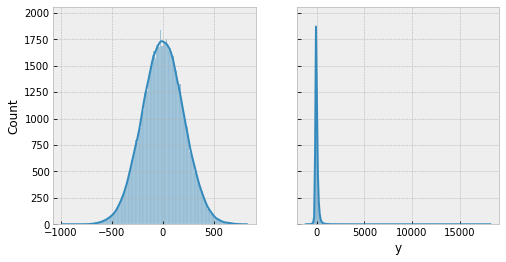

In [74]:
# Comparación de la distribución teórica(normal) y empirica de los errores
media = np.mean(errores)
des_est = np.std(errores)
n = len(y_test)
errores_teoricos = np.random.normal(media, des_est, n)

fig, ax = plt.subplots(1, 2, figsize=(8, 4), sharey='all')
for dat, subplot in zip((errores_teoricos, errores), ax.flatten()):
    sns.histplot(x=dat, ax=subplot, kde=True )

plt.show()

In [75]:
# Error cuadrado medio (MSE) linea base (promedio de las etiquetas)

errores_lb = y_test - y_test.mean()
MSE_base = pow(errores_lb,2).sum()/len(errores_lb)
MSE_base

52114.94299180111

In [76]:
#Error cuadrado medio (MSE) modelo
errores = y_test - y_pred

MSE_modelo = pow(errores,2).sum()/len(errores)
MSE_modelo

40795.63580129677

In [77]:
R2 = 1 - MSE_modelo/MSE_base #¿cuánto mejora la predicción nuestro modelo?
R2

0.2171988788759709

In [78]:
def R_cuadrada(val_obs, val_pred):
  errores_lb = val_obs - val_obs.mean()
  errores_m = val_obs - val_pred
  MSE_base = pow(errores_lb,2).sum()/len(errores_lb)
  MSE_modelo = pow(errores,2).sum()/len(errores)
  R2 = 1 - MSE_modelo/MSE_base
  return R2

In [79]:
R_cuadrada(y_test, y_pred)

0.2171988788759709

In [80]:
metrics.r2_score(y_test, y_pred)

0.2171988788759709

### Regresión Robusta

In [81]:
hr = HuberRegressor(epsilon=1.35,   max_iter=1000,  alpha=0,  warm_start=False,
                    fit_intercept=True, tol=1e-05)
hr = hr.fit(X_train, y_train)
y_pred_hr = hr.predict(X_test)

print(metrics.mean_absolute_error(y_test, y_pred_hr))
print('MAE:', metrics.mean_absolute_error(y_test, y_pred_hr))

103.88839975467025
MAE: 103.88839975467025


In [82]:
hr.coef_

array([ -9.32976541,   0.9124011 ,   0.07046131,  -1.00136883,
       -12.73591401,   9.7296993 ,   2.0077257 ,   5.35117331,
        12.59906784,  62.30358211,  28.79339995,   8.61749604,
         3.47730703,   0.57917116,  10.44785286,   5.02058091,
         0.85053443,  11.45908906,   6.03761218,   4.99285301,
         6.59382418,   1.96947763,   3.14313   ,   1.48187023,
         0.55729766,   0.68306584,   1.93068771,   1.32241273,
         3.22387255,   3.30045459,   2.11777071, -50.21093826,
         0.32779955,   1.57489069,   9.03512798,  17.48787913,
        15.04987582,   3.24733298,  17.08341539,  19.80286797,
         1.60987303,   1.95985471,   1.37871429,   9.05213486,
        -0.09809226,   4.69075037,  -0.88618129,   4.51165418,
         0.72569152,   2.33390028,  -0.63372247,   0.36618853,
        -0.06356353,  -0.54648555,   0.61385128,  -3.34023872,
        -0.31998251,  -1.17714812,  -0.4463794 ,   5.88109971,
         1.16997434,  -0.46014527,   2.42610581,   3.05

In [83]:
coeficientes_hr = pd.DataFrame({'coef':hr.coef_, 'variable':list(X.columns)})
coeficientes_hr.sort_values('coef').reset_index(drop=True)

,coef,variable
0,-50.210938,location of the event_131
1,-33.362698,emergency vehicle type_AR
2,-14.705818,location of the event_325
3,-12.735914,fin_semana
4,-9.730351,emergency vehicle type_CRF
...,...,...
116,28.793400,alert reason category_9
117,33.774115,emergency vehicle type_FA
118,37.721443,emergency vehicle type_PSE
119,47.254758,emergency vehicle type_FPT BSPP


# Selección del modelo

# Que parte de lo desarrollado es útil para el despliegue del modelo